In [63]:
import librosa
import numpy as np
import os

# Paths to audio files
clean_path = "/Users/samcourtney/Downloads/DNS-Challenge/clean_output"
noisy_path = "/Users/samcourtney/Downloads/DNS-Challenge/noisy_output"

# Load audio files
clean_files = [os.path.join(clean_path, f) for f in os.listdir(clean_path)]
noisy_files = [os.path.join(noisy_path, f) for f in os.listdir(noisy_path)]

# Load one pair to test
clean_audio, sr = librosa.load(clean_files[0], sr=16000)  # 16kHz sample rate
noisy_audio, _ = librosa.load(noisy_files[0], sr=16000)

print(len(clean_files), len(noisy_files))

print(os.path.exists(clean_path), os.path.exists(noisy_path))
print(os.listdir(clean_path)[:2], os.listdir(noisy_path)[:2])
print(len(clean_files), len(noisy_files))

361 361
True True
['clean_fileid_223.wav', 'clean_fileid_237.wav'] ['p300_014_mic1_seg1-p316_209_mic1_seg1-p272_029_mic1_seg1-p287_091_mic2_seg1_BatGg1Wwhz4_snr-1_tl-33_fileid_124.wav', 'p335_016_mic1_seg1-p297_005_mic1_seg1_bnCiy9pQbHM_snr-3_tl-29_fileid_341.wav']
361 361


In [ ]:
print(pred[0].min(), pred[0].max(), pred[0].mean())

2.3603088e-09 0.15945539 0.0029164453


In [ ]:
# Compute STFT
n_fft = 512
hop_length = 128
clean_spec = np.abs(librosa.stft(clean_audio, n_fft=n_fft, hop_length=hop_length))
noisy_spec = np.abs(librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length))

# Normalize spectrograms by maximum only (preserve magnitude scale)
clean_spec = clean_spec / (np.max(clean_spec) + 1e-10)
noisy_spec = noisy_spec / (np.max(noisy_spec) + 1e-10)

# Check shapes
print(clean_spec.shape, noisy_spec.shape)

In [65]:
# Normalization of spectrograms
X_train, y_train = [], []
n_fft = 512
hop_length = 128

for clean_file, noisy_file in zip(clean_files, noisy_files):
    clean_audio, _ = librosa.load(clean_file, sr=16000)
    noisy_audio, _ = librosa.load(noisy_file, sr=16000)
    clean_spec = np.abs(librosa.stft(clean_audio, n_fft=n_fft, hop_length=hop_length))
    noisy_spec = np.abs(librosa.stft(noisy_audio, n_fft=n_fft, hop_length=hop_length))
    # Scale to max 1.0 without shifting min
    clean_spec = clean_spec / (np.max(clean_spec) + 1e-10)
    noisy_spec = noisy_spec / (np.max(noisy_spec) + 1e-10)
    X_train.append(noisy_spec[..., np.newaxis])
    y_train.append(clean_spec[..., np.newaxis])

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.min(), X_train.max(), X_train.mean())
print(y_train.min(), y_train.max(), y_train.mean())

0.0 1.0 0.010091137
0.0 1.0 0.0066029755


In [66]:
from sklearn.model_selection import train_test_split

# Split into train (80%), validation (10%), test (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Check shapes
print(X_train.shape, X_val.shape, X_test.shape)  # Expected: ~288, ~36, ~36 samples

(288, 257, 1251, 1) (36, 257, 1251, 1) (37, 257, 1251, 1)


In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(257, 1251, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
    layers.Cropping2D(((1, 2), (0, 1)))  # Adjusted to get 257x1251
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 257, 1251, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 129, 626, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 129, 626, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 65, 313, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 65, 313, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 130, 626, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 130, 626, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 260, 1252, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 260, 1252, 1)   │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_5 (Cropping2D)       │ (None, 257, 1251, 1)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Train model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
)
model.save('noise_reduction_model.keras')

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - loss: 0.2416 - val_loss: 0.2311
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.2237 - val_loss: 0.1884
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - loss: 0.1665 - val_loss: 0.0818
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - loss: 0.0558 - val_loss: 0.0075
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.0048 - val_loss: 0.0016
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - loss: 9.9907e-04 - val_loss: 9.7232e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - loss: 9.5340e-04 - val_loss: 9.3794e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - loss: 9.2343e-04 - val_loss: 9.1651e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - loss: 8.9918e-04 - val_loss: 9.0292e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━

In [69]:
model.save('noise_reduction_model.keras')

In [70]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
pred = model.predict(X_test[:1])
print(pred[0].min(), pred[0].max(), pred[0].mean())

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - loss: 8.9039e-04
Test loss: 0.000880122184753418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2.3603088e-09 0.15945539 0.0029164453


In [ ]:
# Convert predicted spectrogram to audio with proper phase information
import librosa
import numpy as np
import soundfile as sf

# Get the original noisy audio for phase information
noisy_audio_for_phase, _ = librosa.load(noisy_files[0], sr=16000)

# Get complex STFT (with phase) from original noisy audio
noisy_stft = librosa.stft(noisy_audio_for_phase, hop_length=128, n_fft=512)
noisy_phase = np.angle(noisy_stft)

# Use predicted magnitude with original phase
pred_spec = pred[0][:, :, 0]
pred_spec = pred_spec * np.max(np.abs(noisy_stft))  # Restore original scale
pred_complex = pred_spec * np.exp(1j * noisy_phase)  # Combine magnitude and phase
pred_audio = librosa.istft(pred_complex, hop_length=128, n_fft=512)
sf.write('pred_audio.wav', pred_audio, 16000)

# For comparison, also reconstruct test audio properly
test_spec = X_test[0][:, :, 0] * np.max(np.abs(noisy_stft))
test_complex = test_spec * np.exp(1j * noisy_phase)
test_audio = librosa.istft(test_complex, hop_length=128, n_fft=512)
sf.write('test_audio.wav', test_audio, 16000)

In [72]:
print(pred[0].min(), pred[0].max(), pred[0].mean())

2.3603088e-09 0.15945539 0.0029164453


In [73]:
print(X_train.min(), X_train.max(), X_train.mean())
print(y_train.min(), y_train.max(), y_train.mean())

0.0 1.0 0.010082202
0.0 1.0 0.0065916996


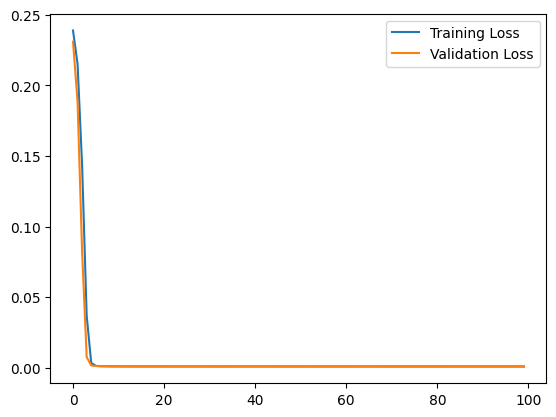

In [74]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [75]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
pred = model.predict(X_test[:1])
print(pred[0].min(), pred[0].max(), pred[0].mean())

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - loss: 8.9039e-04
Test loss: 0.000880122184753418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2.3603088e-09 0.15945539 0.0029164453


In [76]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
pred = model.predict(X_test[:1])
print(pred[0].min(), pred[0].max(), pred[0].mean())

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - loss: 8.9039e-04
Test loss: 0.000880122184753418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2.3603088e-09 0.15945539 0.0029164453


In [ ]:
import librosa
import numpy as np
import soundfile as sf

# Load one original clean audio
clean_audio, sr = librosa.load(clean_files[0], sr=16000)
sf.write('original_clean.wav', clean_audio, 16000)

# Convert to spectrogram and back with proper phase preservation
clean_stft = librosa.stft(clean_audio, n_fft=512, hop_length=128)
clean_spec = np.abs(clean_stft)
clean_spec = clean_spec / (np.max(clean_spec) + 1e-10)  # Normalize by max only
clean_phase = np.angle(clean_stft)
clean_complex = clean_spec * np.max(np.abs(clean_stft)) * np.exp(1j * clean_phase)
recon_audio = librosa.istft(clean_complex, hop_length=128, n_fft=512)
sf.write('reconstructed_clean.wav', recon_audio, 16000)

In [ ]:
# Test audio amplitude levels
import librosa
import numpy as np
import soundfile as sf

# Load original audio and check levels
clean_audio, sr = librosa.load(clean_files[0], sr=16000)
print(f"Original clean audio - min: {clean_audio.min():.6f}, max: {clean_audio.max():.6f}, RMS: {np.sqrt(np.mean(clean_audio**2)):.6f}")

# Test simple spectrogram -> audio conversion
clean_stft = librosa.stft(clean_audio, n_fft=512, hop_length=128)
reconstructed_audio = librosa.istft(clean_stft, hop_length=128, n_fft=512)
print(f"Simple reconstruction - min: {reconstructed_audio.min():.6f}, max: {reconstructed_audio.max():.6f}, RMS: {np.sqrt(np.mean(reconstructed_audio**2)):.6f}")

# Save both for comparison
sf.write('original_clean.wav', clean_audio, 16000)
sf.write('simple_reconstruction.wav', reconstructed_audio, 16000)

# Now test with normalization/denormalization
clean_spec = np.abs(clean_stft)
original_max = np.max(clean_spec)
normalized_spec = clean_spec / (original_max + 1e-10)
denormalized_spec = normalized_spec * original_max
clean_phase = np.angle(clean_stft)
final_complex = denormalized_spec * np.exp(1j * clean_phase)
final_audio = librosa.istft(final_complex, hop_length=128, n_fft=512)
print(f"Normalized reconstruction - min: {final_audio.min():.6f}, max: {final_audio.max():.6f}, RMS: {np.sqrt(np.mean(final_audio**2)):.6f}")
sf.write('normalized_reconstruction.wav', final_audio, 16000)